In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json
import shutil
import healpy
from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess
import scipy.misc

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
MEDIUM_SIZE = 30
SMALL_SIZE = 22
SSSMALL_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)
os.environ['PATH'] = '/global/common/sw/cray/sles15/x86_64/texlive/live/gcc/8.2.0/tiozj27/bin/x86_64-linux/:{}'.format(os.environ['PATH'])

In [4]:
data = {}
cuts = ['A', 'B', 'C', 'D', 'E']
for cut in cuts:
    mtl_filename = os.path.join("targets/mtl_cut_{}_dark_south.fits".format(cut))
    filein = fitsio.FITS(mtl_filename, 'r')
    data[cut] = filein[1].read()
    filein.close()

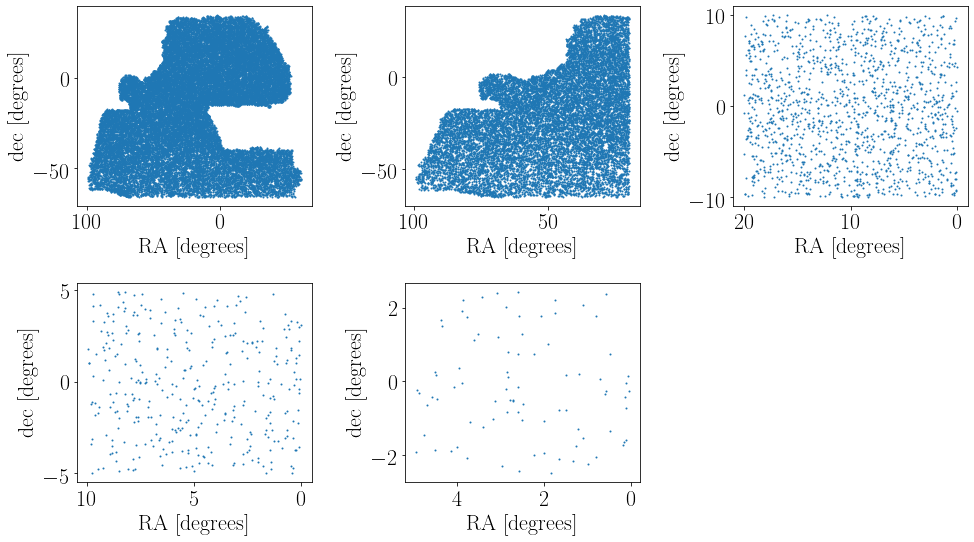

In [5]:
i = 1
cuts = ['A', 'B', 'C', 'D', 'E']

plt.figure(figsize=(14,8))
for cut in cuts:
    n_target = len(data[cut])
    r = np.random.random(n_target)
    rr = r<0.001
    plt.subplot(2,3,i)
    ii = data[cut]['RA']>180.0
    data[cut]['RA'][ii] = data[cut]['RA'][ii]-360.0
    plt.scatter(data[cut]['RA'][rr], data[cut]['DEC'][rr], s=1)
    i = i+1
    
    plt.xlabel("RA [degrees]")
    plt.ylabel("dec [degrees]")
    plt.gca().invert_xaxis()


plt.tight_layout()
plt.savefig("DR8_footprint_cuts.pdf", bbox_inches='tight')

In [7]:
summary_file = "summary/fba_summary_mtl_dark_south_cut_C_tiles_cut_C.fits"
filein = fitsio.FITS(summary_file, 'r')
summary_all = filein[1].read()
filein.close()
ii = summary_all['NAVAIL_TILE']>0
summary = summary_all[ii]
del summary_all

[1 2 3 4 5 6 7 8 9] 4.514538918745774
[4.51453892e+00 2.03810616e+01 9.20110960e+01 4.15387674e+02
 1.87528382e+03 8.46604179e+03 3.82202752e+04 1.72546920e+05
 7.78969784e+05] [1.0000e+00 2.0000e+00 6.0000e+00 2.4000e+01 1.2000e+02 7.2000e+02
 5.0400e+03 4.0320e+04 3.6288e+05]


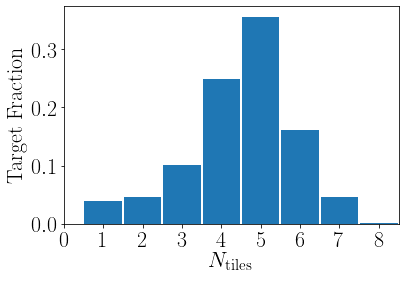

In [36]:
_ = plt.hist(summary['NAVAIL_TILE'], bins=np.arange(12)-0.5, rwidth=0.95, density=True)
_ = plt.xticks(ticks=np.arange(0,11))
plt.xlim([0,8.5])

lam = np.mean(summary['NAVAIL_TILE'])
n = np.arange(1,10)
print(n, lam)
print(lam**n, scipy.special.factorial(n))
p_n = np.exp(-lam)*(lam**n)/scipy.special.factorial(n)
#plt.scatter(n, p_n, color='red')
plt.xlabel("$N_{\mathrm{tiles}}$")
plt.ylabel("Target Fraction")
plt.savefig("DR8_navail_tile.pdf", bbox_inches='tight')

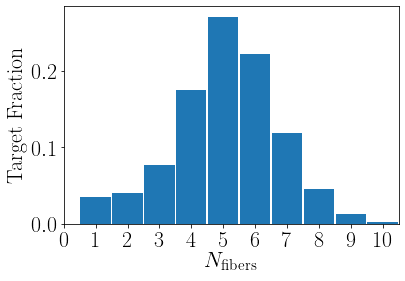

In [11]:
_ = plt.hist(summary['NAVAIL_FIBER'], bins=np.arange(12)-0.5, rwidth=0.95, density=True)
_ = plt.xticks(ticks=np.arange(0,11))
plt.xlim([0,10.5])
plt.xlabel("$N_{\mathrm{fibers}}$")
plt.ylabel("Target Fraction")
plt.savefig("DR8_navail_fiber.pdf", bbox_inches='tight')

In [149]:
def plot_sky_circle(x, y, radius, alpha=0.1):
    theta = np.linspace(0, 2*np.pi, 50)
    xx = x + np.cos(np.radians(y))*radius*np.cos(theta)
    yy = y + radius*np.sin(theta)
    plt.fill(xx, yy, alpha=alpha, color='blue')


def plot_tile(ra, dec, alpha=0.1):
    tile_radius = desimodel.focalplane.get_tile_radius_deg()
    plot_sky_circle(ra, dec, tile_radius)

In [150]:
tiles = Table.read("tiles/tiles_cut_C_dark_north.fits")

all_tiles = desimodel.footprint.load_tiles()
ii = ~(all_tiles['PROGRAM']=='BRIGHT')
all_tiles = all_tiles[ii]

In [151]:
len(all_tiles)

9990

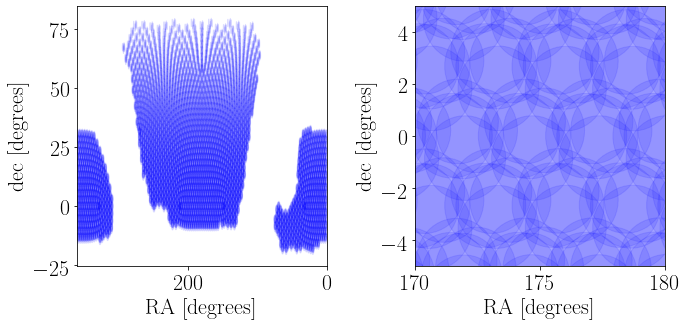

In [156]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for i in range(len(all_tiles)):
    plot_tile(all_tiles['RA'][i], all_tiles['DEC'][i])
plt.xlabel('RA [degrees]')
plt.ylabel('dec [degrees]')
plt.gca().invert_xaxis()
plt.xlim([360,0])


plt.subplot(1,2,2)
for i in range(len(tiles)):
    plot_tile(tiles['RA'][i], tiles['DEC'][i])
plt.xlabel('RA [degrees]')
plt.ylabel('dec [degrees]')
plt.xlim([170,180])
plt.ylim([-5,5])

plt.tight_layout()
plt.savefig("DR8_dark_tiles.pdf", bbox_inches='tight')